Train set shape: (36808,), Test set shape: (9203,)


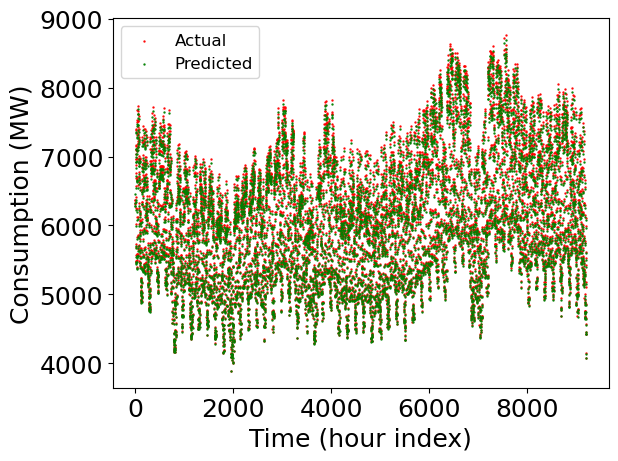

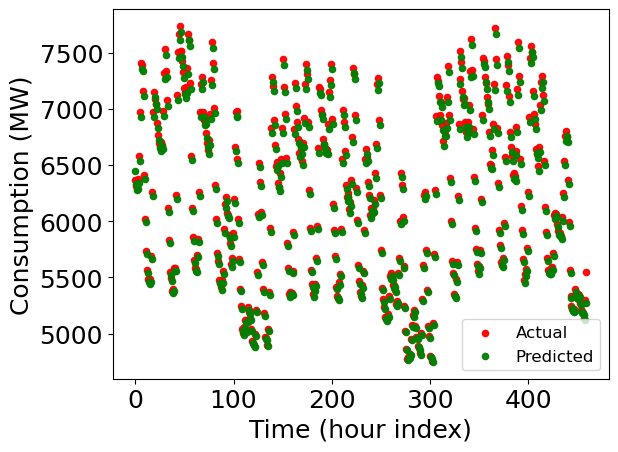

RMSE = 287.0569771, RMSE % = 4.62


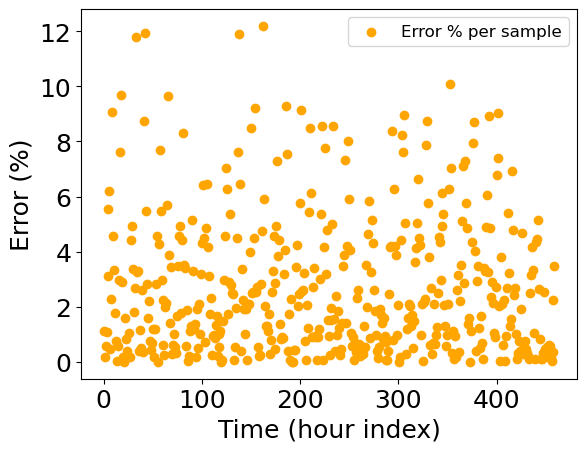

In [8]:
# Transfer Learning: Two-Wire Model-2 for Hourly Electricity Consumption and Production
# https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from qutip import Qobj, wigner
import seaborn as sns

# Load Data
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\LF_Kaggle.csv', header=None)
LoadData[1] = pd.to_numeric(LoadData[1], errors='coerce')
X = np.array(LoadData[1].values[1:])
Y = np.array(LoadData[1].values[2:])
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

# Quantum Neural Network (QNN) setup
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Optimized Weights
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Ensure Predictions and Test Data Are of Same Length
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Set Global Font Size for Plots
plt.rcParams.update({'font.size': 18})

# Plot Predictions vs Actual for Full Test Data
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Actual', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted', alpha=0.95, s=0.5)
plt.xlabel("Time (hour index)")
plt.ylabel("Consumption (MW)")
plt.legend()
plt.show()

# Plot Predictions vs Actual for 5% of Test Data
num_samples_to_plot = int(len(X_test) * 0.05)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Actual', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted', alpha=0.95, s=20)
plt.xlabel("Time (hour index)")
plt.ylabel("Consumption (MW)")
plt.legend()
plt.show()

# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100
print(f"RMSE = {rmse:.7f}, RMSE % = {rmse_percentage:.2f}")

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Time (hour index)")
plt.ylabel("Error (%)")
plt.legend()
plt.show()


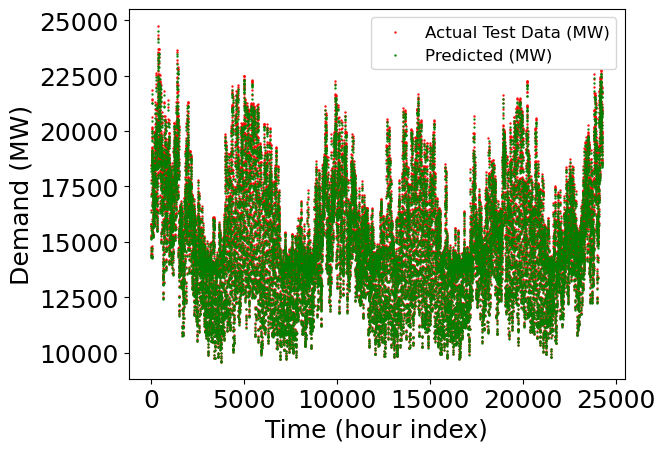

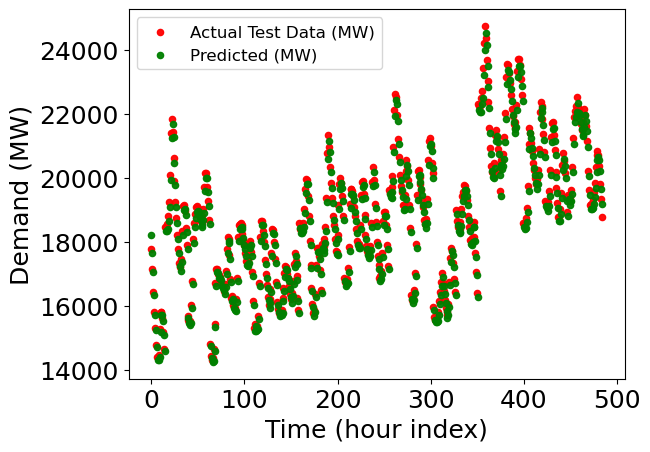

RMSE = 717.4634953, RMSE % = 3.82


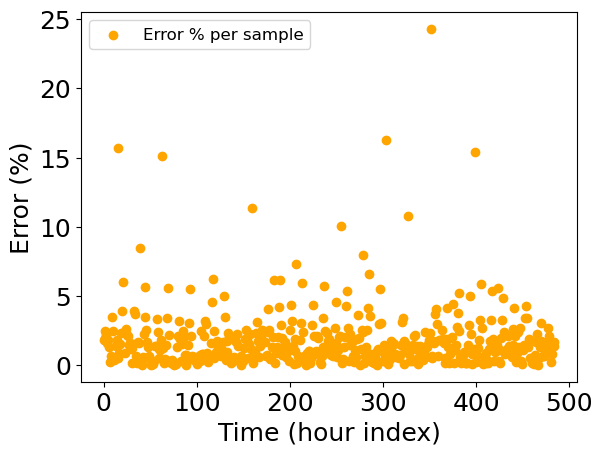

In [1]:
# Kaggle Dataset 2 - AEP hourly-energy-consumption
# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})

# Load and Preprocess Data
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\LF_Kaggle2.csv', header=None)
LoadData[1] = pd.to_numeric(LoadData[1], errors='coerce')
X = np.array(LoadData[1].values[1:])
Y = np.array(LoadData[1].values[2:])
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]

# Define Quantum Device
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define Quantum Layer
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

# Define Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Pretrained Parameters
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

test_samples = len(X_test)
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Plot Full Data Predictions vs Actual
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Actual Test Data (MW)', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted (MW)', alpha=0.95, s=0.5)
plt.xlabel("Time (hour index)")
plt.ylabel("Demand (MW)")
plt.legend(fontsize=12)
plt.show()

# Plot 2% of Data Predictions vs Actual
num_samples_to_plot = int(test_samples * 0.02)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Actual Test Data (MW)', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted (MW)', alpha=0.95, s=20)
plt.xlabel("Time (hour index)")
plt.ylabel("Demand (MW)")
plt.legend(fontsize=12)
plt.show()

# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100
print(f"RMSE = {rmse:.7f}, RMSE % = {rmse_percentage:.2f}")

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Time (hour index)")
plt.ylabel("Error (%)")
plt.legend(fontsize=12)
plt.show()



Train set shape: (11672,), Test set shape: (2919,)


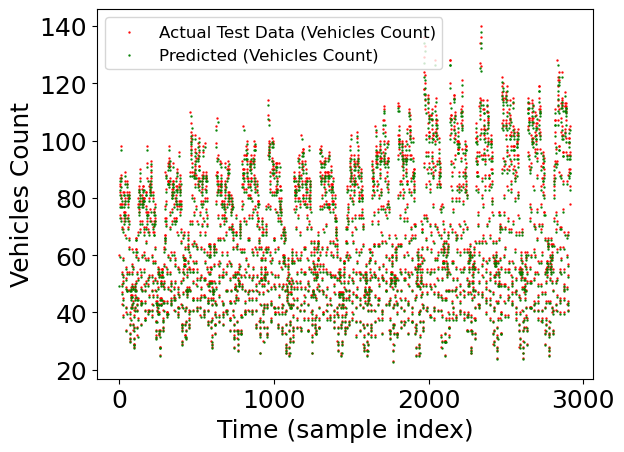

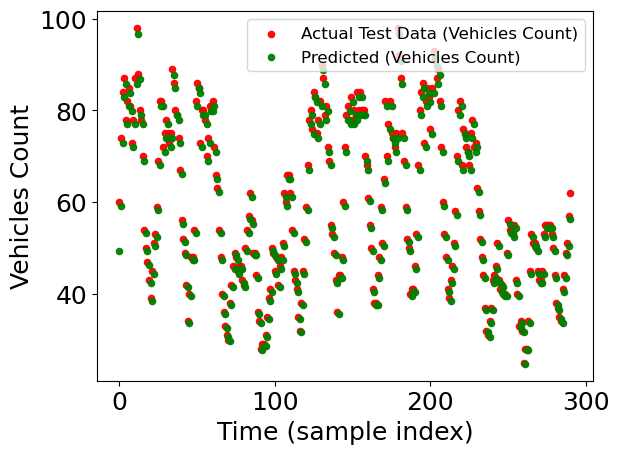

RMSE = 6.5777897, RMSE % = 11.10


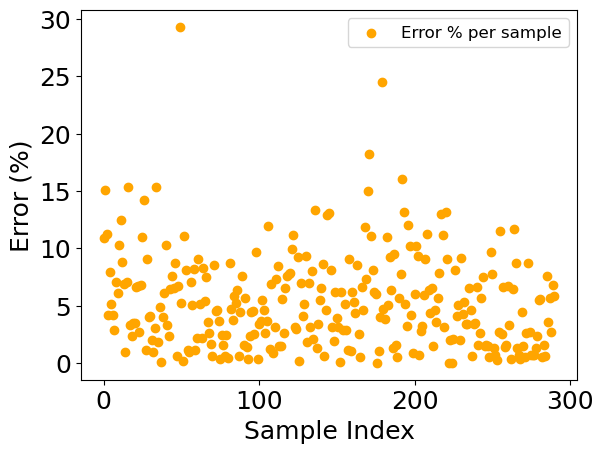

In [7]:
# Traffic Prediction Dataset
# Hourly traffic data on four different junctions
# https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set global font size for plots
plt.rcParams.update({'font.size': 18})

# Load and Filter Data
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\Traffic_Kaggle.csv')
LoadData = LoadData[LoadData['Junction'] == 1]
LoadData['Vehicles'] = pd.to_numeric(LoadData['Vehicles'], errors='coerce')
LoadData = LoadData.dropna(subset=['Vehicles'])

# Prepare Data for Forecasting
X = np.array(LoadData['Vehicles'].values[:-1])
Y = np.array(LoadData['Vehicles'].values[1:])

# Scale Data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

# Split Data into Train and Test Sets
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

# Define Quantum Device
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define Quantum Layer
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

# Define Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Pretrained Parameters
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Trim Data for Visualization
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Plot Full Data Predictions vs Actual
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Actual Test Data (Vehicles Count)', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted (Vehicles Count)', alpha=0.95, s=0.5)
plt.xlabel("Time (sample index)")
plt.ylabel("Vehicles Count")
plt.legend(fontsize=12) 
plt.show()

# Plot 10% of Data Predictions vs Actual
num_samples_to_plot = int(len(X_test) * 0.1)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Actual Test Data (Vehicles Count)', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted (Vehicles Count)', alpha=0.95, s=20)
plt.xlabel("Time (sample index)")
plt.ylabel("Vehicles Count")
plt.legend(fontsize=12)
plt.show()


# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100
print(f"RMSE = {rmse:.7f}, RMSE % = {rmse_percentage:.2f}")

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Sample Index")
plt.ylabel("Error (%)")
plt.legend(fontsize=12)
plt.show()




Train set shape: (77161,), Test set shape: (19291,)


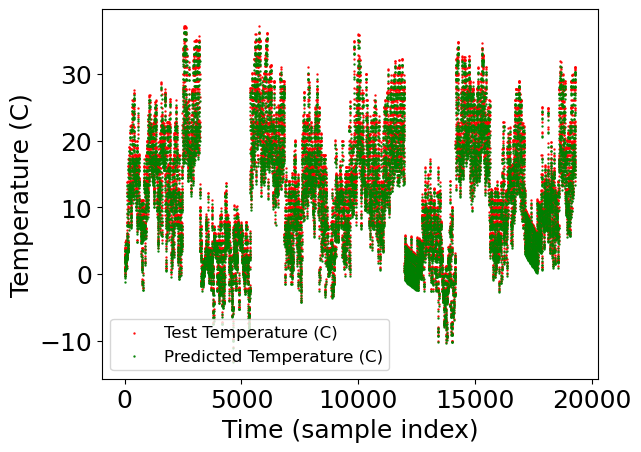

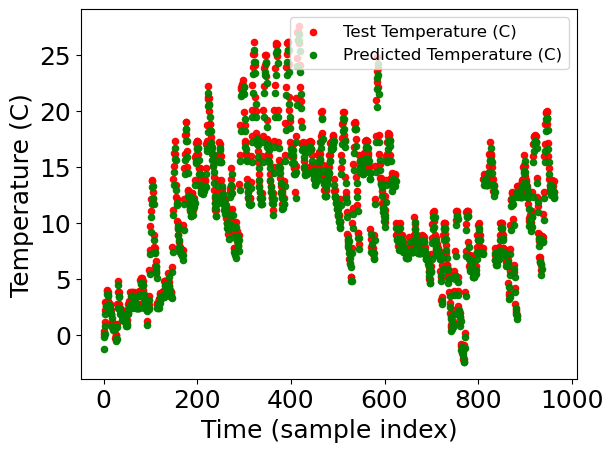

RMSE = 1.3530237, RMSE % = 12.06


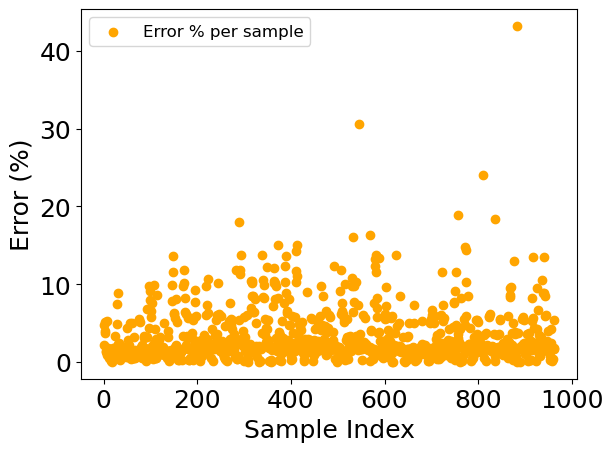

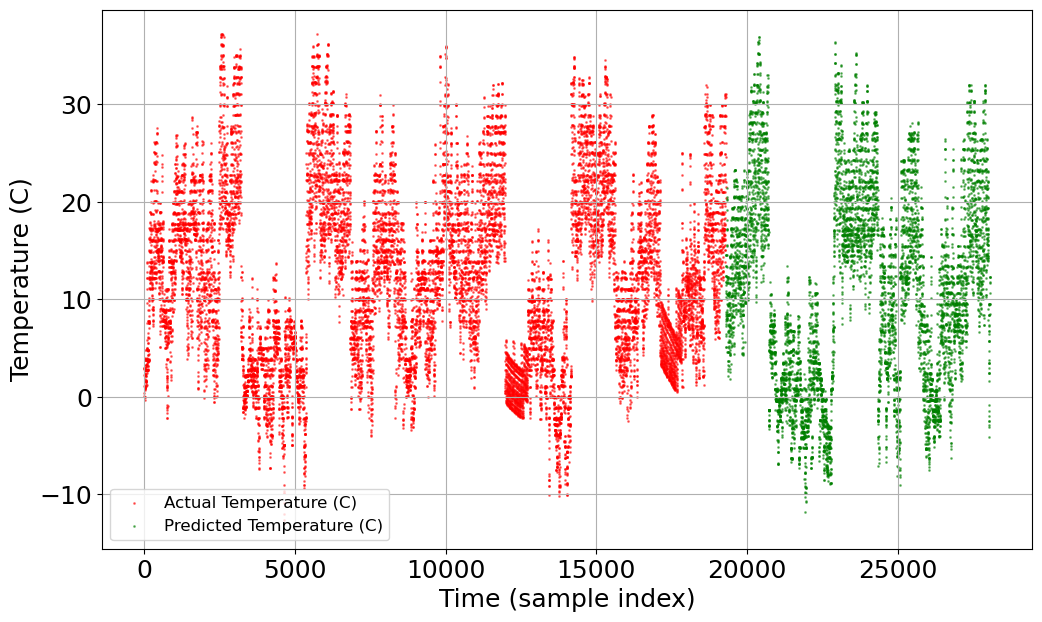

In [10]:
# Weather Prediction
# https://www.kaggle.com/datasets/muthuj7/weather-dataset

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and Filter Data
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\WeatherHistory_Kaggle.csv')
LoadData['Temperature (C)'] = pd.to_numeric(LoadData['Temperature (C)'], errors='coerce')
LoadData = LoadData.dropna(subset=['Temperature (C)'])

# Prepare Data for Forecasting
X = np.array(LoadData['Temperature (C)'].values[:-1])
Y = np.array(LoadData['Temperature (C)'].values[1:])

# Scale Data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

# Split Data into Train and Test Sets
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

# Define Quantum Device
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define Quantum Layer
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

# Define Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Pretrained Parameters
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Trim Data for Visualization
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Set Global Font Size and Legend Font Size
plt.rcParams.update({'font.size': 18, 'legend.fontsize': 12})

# Plot Full Data Predictions vs Actual
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Test Temperature (C)', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted Temperature (C)', alpha=0.95, s=0.5)
plt.xlabel("Time (sample index)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

# Plot 5% of Data Predictions vs Actual
num_samples_to_plot = int(len(X_test) * 0.05)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Test Temperature (C)', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted Temperature (C)', alpha=0.95, s=20)
plt.xlabel("Time (sample index)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100
print(f"RMSE = {rmse:.7f}, RMSE % = {rmse_percentage:.2f}")

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Sample Index")
plt.ylabel("Error (%)")
plt.legend()
plt.show()

# Function to Predict Future Temperature
def predict_future(var, X_initial, window_size, days):
    future_predictions = []
    if len(X_initial) < window_size:
        raise ValueError("X_initial must have at least 'window_size' elements.")
    window = list(X_initial[-window_size:])
    for _ in range(days):
        input_data = window[-365*6*24]
        prediction_encoded = quantum_neural_net(var, x=input_data)[0]
        prediction_original_scale = scaler.inverse_transform(np.array(prediction_encoded).reshape(-1, 1)).flatten()[0]
        future_predictions.append(prediction_original_scale)
        window.pop(0)
        window.append(scaler.transform([[prediction_original_scale]]).flatten()[0])
    return future_predictions

# Set Future Prediction Parameters
future_days = 365 * 1 * 24
window_size = 365 * 11 * 24
X_combined = np.concatenate((X_train, X_test))

# Generate Future Predictions
future_predictions = predict_future(var, X_combined, window_size=window_size, days=future_days)
Y_test_original_scale = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1)).flatten()

# Prepare Data for Plotting
x_axis_actual = range(len(Y_test_original_scale))
x_axis_predictions = range(len(Y_test_original_scale), len(Y_test_original_scale) + future_days)
Y_combined = list(Y_test_original_scale) + future_predictions

# Plot Actual and Predicted Temperature
plt.figure(figsize=(12, 7))
plt.scatter(x_axis_actual, Y_test_original_scale, label="Actual Temperature (C)", color="red", s=1, alpha=0.5)
plt.scatter(x_axis_predictions, future_predictions, label="Predicted Temperature (C)", color="green", s=1, alpha=0.5)
plt.xlabel("Time (sample index)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.grid()
plt.show()


Train set shape: (60531,), Test set shape: (15133,)


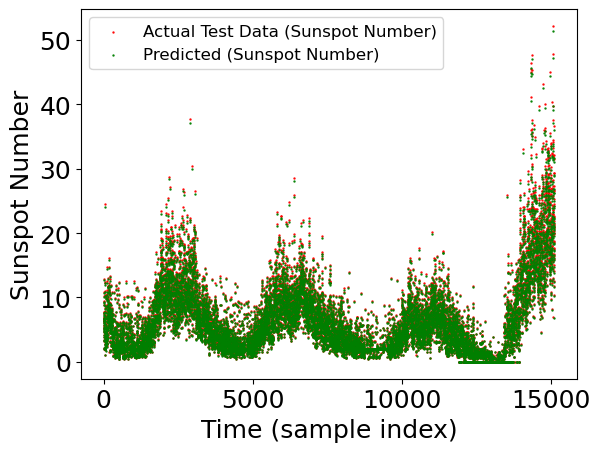

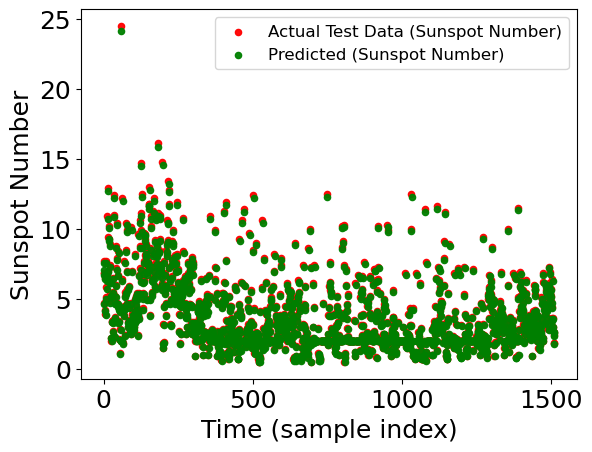

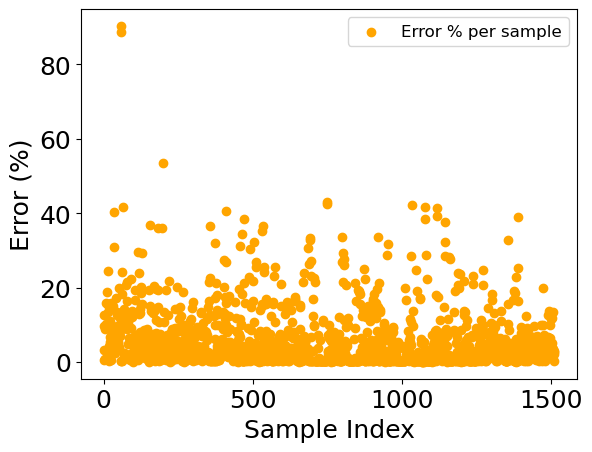

In [4]:
# Sunspot Number Prediction
# https://www.sidc.be/SILSO/datafiles

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set global font size for plots
plt.rcParams.update({'font.size': 18})

# Load the dataset
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\SN_d_tot_V2.0.csv', header=None)  # Adjust delimiter if needed

# Extract the 4th column (index 3) starting from the 2nd row (index 1)
target_values = pd.to_numeric(LoadData.iloc[0:, 5], errors='coerce').dropna()

# Prepare the data for forecasting
X = np.array(target_values.values[:-1])  # Current values as input
Y = np.array(target_values.values[1:])   # Next time step's values as output

# Scale the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

# Define Quantum Device
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define Quantum Layer
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

# Define Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Pretrained Parameters
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Trim Data for Visualization
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Plot Full Data Predictions vs Actual
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Actual Test Data (Sunspot Number)', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted (Sunspot Number)', alpha=0.95, s=0.5)
plt.xlabel("Time (sample index)")
plt.ylabel("Sunspot Number")
plt.legend(fontsize=12)
plt.show()

# Plot 10% of Data Predictions vs Actual
num_samples_to_plot = int(len(X_test) * 0.1)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Actual Test Data (Sunspot Number)', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted (Sunspot Number)', alpha=0.95, s=20)
plt.xlabel("Time (sample index)")
plt.ylabel("Sunspot Number")
plt.legend(fontsize=12)
plt.show()

# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Sample Index")
plt.ylabel("Error (%)")
plt.legend(fontsize=12)
plt.show()


Train set shape: (1577,), Test set shape: (395,)


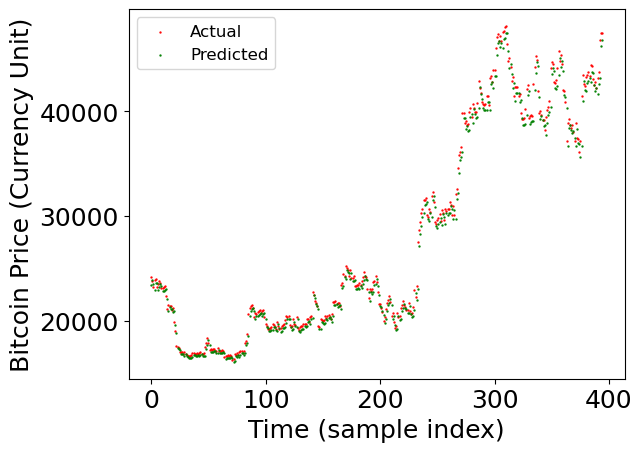

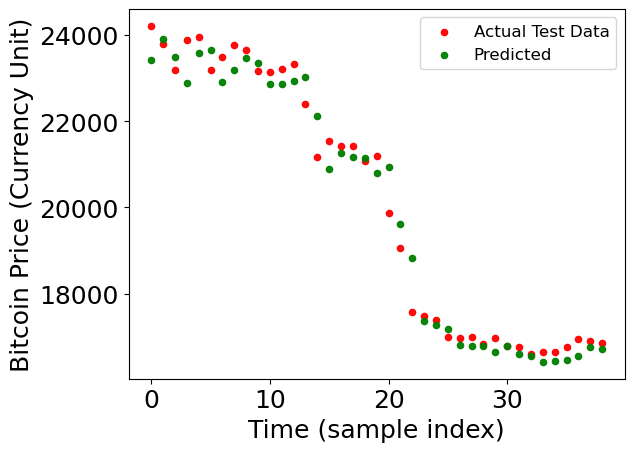

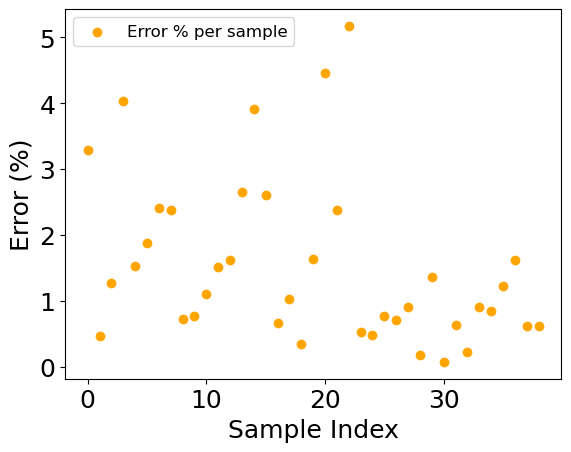

In [7]:
# Cryptocurrency Price Prediction
# https://www.kaggle.com/datasets/adityamhaske/cryptocurrency-price-analysis-dataset

import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set global font size for plots
plt.rcParams.update({'font.size': 18})

# Load and filter BTC data
LoadData = pd.read_csv(r'C:\Users\ismae\A1_Pennylane\LF\Cryptography\BTC.csv')
BTC_data = LoadData.iloc[1:, 3].values.astype(float)
BTC_data = pd.to_numeric(BTC_data, errors='coerce')
BTC_data = BTC_data[~np.isnan(BTC_data)]

# Prepare the data for forecasting
X = np.array(BTC_data[:-1])
Y = np.array(BTC_data[1:])

# Scale the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).flatten()
Y_normalized = scaler.transform(Y.reshape(-1, 1)).flatten()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X_normalized) * 0.8)
X_train = X_normalized[:train_size]
Y_train = Y_normalized[:train_size]
X_test = X_normalized[train_size:]
Y_test = Y_normalized[train_size:]
print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

# Define Quantum Device
cutoff_dim = 12
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=cutoff_dim)

# Define Quantum Layer
def layer(v):
    qml.Beamsplitter(v[0], v[1], wires=[0, 1])
    qml.Rotation(v[2], wires=0)
    qml.Squeezing(v[3], v[4], wires=0)
    qml.CubicPhase(v[5], wires=0)

# Define Quantum Neural Network
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    qml.Displacement(x, -np.pi/2, wires=0)
    qml.Displacement(x, -np.pi/2, wires=1)
    for v in var:
        layer(v)
    return qml.expval(qml.X(0)), qml.expval(qml.X(1))

# Load Pretrained Parameters
var = np.load(r'C:\Users\ismae\A1_Pennylane\LF\Optimized_weights_simplification_2.npy')

# Generate Predictions
predictions_test_encoded = [quantum_neural_net(var, x_)[0] for x_ in X_test]
predictions_test_original_scale = scaler.inverse_transform(np.array(predictions_test_encoded).reshape(-1, 1)).flatten()
Y_test_original_scale = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

# Trim Data for Visualization
min_length = min(len(Y_test_original_scale), len(predictions_test_original_scale))
Y_test_trimmed = Y_test_original_scale[:min_length]
predictions_test_trimmed = predictions_test_original_scale[:min_length]

# Plot Full Data Predictions vs Actual
plt.figure()
plt.scatter(range(min_length), Y_test_trimmed, color='red', label='Actual', alpha=0.95, s=0.5)
plt.scatter(range(min_length), predictions_test_trimmed, color="green", label='Predicted', alpha=0.95, s=0.5)
plt.xlabel("Time (sample index)")
plt.ylabel("Bitcoin Price (Currency Unit)")
plt.legend(fontsize=12)
plt.show()

# Plot 10% of Data Predictions vs Actual
num_samples_to_plot = int(len(X_test) * 0.1)
plt.figure()
plt.scatter(range(num_samples_to_plot), Y_test_original_scale[:num_samples_to_plot], color='red', label='Actual Test Data', alpha=0.95, s=20)
plt.scatter(range(num_samples_to_plot), predictions_test_original_scale[:num_samples_to_plot], color="green", label='Predicted', alpha=0.95, s=20)
plt.xlabel("Time (sample index)")
plt.ylabel("Bitcoin Price (Currency Unit)")
plt.legend(fontsize=12)
plt.show()

# Calculate RMSE and RMSE Percentage
error = Y_test_original_scale[:num_samples_to_plot] - predictions_test_original_scale[:num_samples_to_plot]
rmse = np.sqrt(np.mean(error**2))
rmse_percentage = (rmse / np.mean(Y_test_original_scale[:num_samples_to_plot])) * 100

# Plot Error Percentage
error_percentage = (np.abs(error) / np.max(Y_test_original_scale[:num_samples_to_plot])) * 100
plt.figure()
plt.scatter(range(num_samples_to_plot), error_percentage, color='orange', label='Error % per sample', marker='o', linestyle='-')
plt.xlabel("Sample Index")
plt.ylabel("Error (%)")
plt.legend(fontsize=12)
plt.show()
